In [1]:
import matplotlib.pyplot as plt
import sys
import time
import scipy.io as io
import os
from os import listdir
import glob
import time

import csv
import cv2
import numpy as np
from opt_flow import draw_flow

import math
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, binary_opening, binary_dilation, disk,remove_small_objects,label,binary_erosion
from skimage.color import label2rgb

from scipy.signal import find_peaks
from skimage.filters import gaussian

def SimilarityComparison(img10, img20):
    img1 = gaussian(img10, sigma=1)
    img2 = gaussian(img20, sigma=1)
   
    reg_hei,reg_wid = img10.shape
    
    N = reg_hei*reg_wid

    norm_term1 = np.sum(np.multiply(img1,img2))*N
    norm_term2 = np.sum(img1)*np.sum(img2)

    denorm_term1 = N*np.sum(np.multiply(img1,img1))-np.sum(img1)*np.sum(img1)
    denorm_term2 = N*np.sum(np.multiply(img2,img2))-np.sum(img2)*np.sum(img2)

    SC = (norm_term1-norm_term2)*(norm_term1-norm_term2)/(denorm_term1*denorm_term2)
    
    return SC


RootPath = 'Y:\\RDRU_MYBPC3_2021\\Pilot20211011\\IPSC_Plate2\\211011_Brandon_IPSC_Plate2_s96'

OutputPath = 'Y:\\RDRU_MYBPC3_2021\\Pilot20211011_plate2_output\\Plate2_s96'


if not os.path.exists(OutputPath):
    os.mkdir(OutputPath)
    print("Directory " , OutputPath ,  " Created ")
else:    
    print("Directory " , OutputPath ,  " already exists")

#subdirectories = os.listdir(RootPath)
#videoNames = listdir(RootPath)
videoNames = sorted(listdir(RootPath))

ds = 2

Directory  Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s96  Created 


In [2]:
print(videoNames)
subfolder = RootPath
imageNameRoot =  subfolder  + "\\tiff\\*.tif"
        #B9, C2,C4
(dirName,videoFileName) = os.path.split(subfolder)

imageNameRoot0 = dirName
imageNames = sorted(glob.glob(imageNameRoot))
imageNum = len(imageNames)
print(imageNames[0])
print('subfolder: ' + subfolder)
print('ImageName: ' + str(imageNum))
print('videoName: '+ str(videoFileName))

['211011_Brandon_IPSC_Plate2_s96_video_ds.avi', 'frame_001.tif.tif', 'tiff']
Y:\RDRU_MYBPC3_2021\Pilot20211011\IPSC_Plate2\211011_Brandon_IPSC_Plate2_s96\tiff\211011_Brandon_IPSC_Plate2_s96_frame_001.tif.tif
subfolder: Y:\RDRU_MYBPC3_2021\Pilot20211011\IPSC_Plate2\211011_Brandon_IPSC_Plate2_s96
ImageName: 960
videoName: 211011_Brandon_IPSC_Plate2_s96


In [3]:
img0 = cv2.imread(imageNames[0])
######frame10 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
######
######ret, frame10 = cap.read()
frame1 = img0[::ds,::ds,:]
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255


## Specify output
tmp = videoNames[0]
outputFolder = OutputPath+ "\\" + tmp[:-4]

print('outputFolder: ' + outputFolder)
print(outputFolder)
    # Create target Directory if don't exist
if not os.path.exists(outputFolder):
    os.mkdir(outputFolder)
    print("Directory " , outputFolder ,  " Created ")
else:    
    print("Directory " , outputFolder ,  " already exists")


videoOut = outputFolder+'\\' + videoFileName[:-4] + '_opticalFlow.avi'
print('videoOut: '+ videoOut)

fps = 100
hei, wid = prvs.shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
VideoOutput = cv2.VideoWriter(videoOut, fourcc, fps, (2*wid,hei))

magStack = np.zeros([hei, wid, int(imageNum)-1],dtype =  np.float32)
angStack = np.zeros([hei, wid, int(imageNum)-1],dtype =  np.float32)

outputFolder: Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s96\211011_Brandon_IPSC_Plate2_s96_video_ds
Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s96\211011_Brandon_IPSC_Plate2_s96_video_ds
Directory  Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s96\211011_Brandon_IPSC_Plate2_s96_video_ds  Created 
videoOut: Y:\RDRU_MYBPC3_2021\Pilot20211011_plate2_output\Plate2_s96\211011_Brandon_IPSC_Plate2_s96_video_ds\211011_Brandon_IPSC_Plate2_opticalFlow.avi


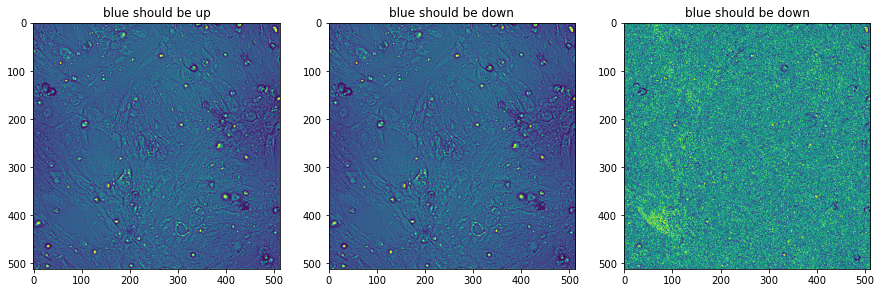

In [4]:
from skimage import exposure

gamma_corrected = exposure.adjust_gamma(prvs, 1)
logarithmic_corrected = exposure.adjust_log(prvs, 5)

fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[0].set_title('blue should be up')
axs[0].imshow(prvs)

axs[1].set_title('blue should be down')
axs[1].imshow(gamma_corrected)

axs[2].set_title('blue should be down')
axs[2].imshow(logarithmic_corrected)


plt.show()



In [5]:
###VideoOutput = cv2.VideoWriter(videoOut, fourcc, fps, (2*wid,hei))
SC_values_ref = np.zeros((int(imageNum)))
                         
print(len(SC_values_ref))       
                         
frame_ref = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
       

960


In [6]:
                  
for ii in range(1,imageNum-1):

    img2 = cv2.imread(imageNames[ii])
    frame20 = img2[::ds,::ds,:]
    frame2 = cv2.cvtColor(frame20,cv2.COLOR_BGR2GRAY)
    
    next = frame2

    SC_values_ref[ii-1] = SimilarityComparison(frame_ref, frame2)
   
    ### Gradient flow
     
    prvs_s = prvs
    next_s = next
    ##prvs_s = exposure.adjust_gamma(prvs_s, 1)
    ##next_s = exposure.adjust_gamma(next_s, 1)
    
    ##prvs_s = exposure.adjust_log(prvs, 5)
    ##next_s = exposure.adjust_log(next, 5)
    
    ###flow_d = next_s-prvs_s
    flow = cv2.calcOpticalFlowFarneback(prvs_s,next_s, None, .5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    hsv[...,2] = mag*10
    #print(np.max(mag))
    ###bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    ###vis = draw_flow(next_s, flow*10)

    magStack[:,:,ii] = mag

    if ii%100==0:
        print(ii)

    prvs = next

    ###frame_final = np.concatenate((bgr,vis),axis=1)
    ###VideoOutput.write(frame_final)
    
###VideoOutput.release() 

100
200
300
400
500
600
700
800
900


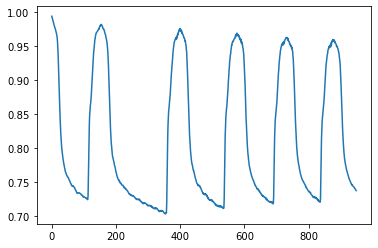

In [7]:
plt.plot(SC_values_ref[1:950])

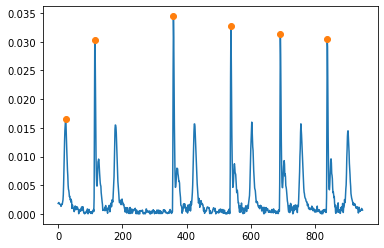

In [8]:
speed = abs(np.gradient(SC_values_ref[1:950]))


maxSpeed = np.max(speed)

speed_Ind, _ = find_peaks(speed, height= maxSpeed/10,distance=80)
plt.plot(speed)
plt.plot(speed_Ind,speed[speed_Ind],"o")



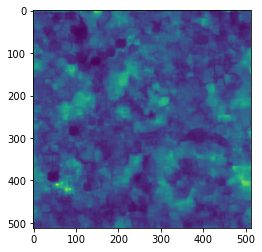

In [9]:
magSum = np.max(magStack,axis=2)
plt.imshow(magSum)

266


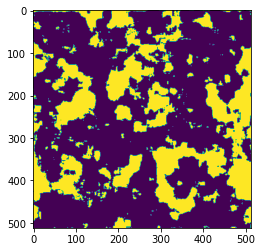

In [10]:
thresh = threshold_otsu(magSum)
mask = magSum>1*thresh
mask_label = label(mask)
print(np.max(mask_label))
plt.imshow(mask_label)
###mask = mask_label==72
plt.imshow(mask)
mask_size = np.sum(mask)


In [11]:
print(magStack.shape[2])
mask_stack = np.repeat(mask[:, :, np.newaxis], magStack.shape[2], axis=2)
print(mask_stack.shape)

959
(512, 512, 959)


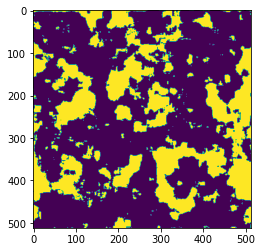

In [12]:
plt.imshow(mask_stack[:,:,200])

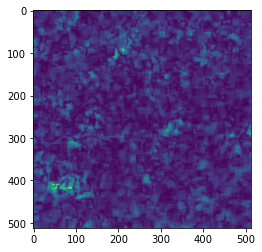

In [13]:
plt.imshow(magStack[:,:,200])

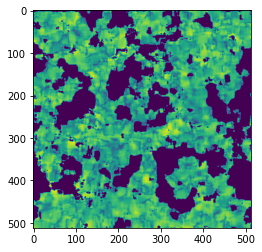

In [14]:
magStack_mask = np.multiply(magStack, 1-mask_stack.astype(int))
plt.imshow(np.log(magStack_mask[:,:,200]+0.001))

(959,)


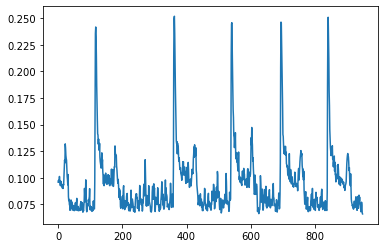

In [15]:
diff_t = np.sum(magStack_mask,axis=0)
diff_t = np.sum(diff_t, axis=0)/mask_size
print(diff_t.shape)
plt.plot(diff_t[1:950])

(959,)


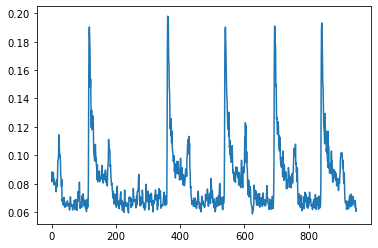

In [16]:
diff_t = np.percentile(magStack_mask,90,axis=0)
diff_t = np.percentile(diff_t,90,axis=0)
print(diff_t.shape)
plt.plot(diff_t[1:950])

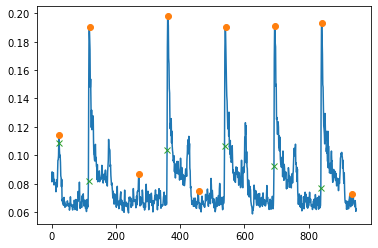

In [17]:
maxVelocity = np.max(diff_t[1:950])

peaks_Ind, _ = find_peaks(diff_t[1:950], height= maxVelocity/3,distance=80)
plt.plot(diff_t[1:950])
plt.plot(1+peaks_Ind,diff_t[1+peaks_Ind],"o")
plt.plot(1+speed_Ind,diff_t[1+speed_Ind],"x")